Так как данные исследования не были представлены в открытом доступе, попробуем провести похожее исследование на другом датасете с медицинскими данными о постановке диагноза.

В качестве датсета был выбран [набор данных](https://www.kaggle.com/datasets/samikshadalvi/pcos-diagnosis-dataset?resource=download), содержащий информацию о пациентках с синдромом поликистозных яичников (СПКЯ), распространенным гормональным расстройством, поражающим женщин репродуктивного возраста. Набор данных состоит из 1000 записей, каждая из которых представляет пациентку, и включает пять ключевых характеристик, обычно связанных с диагнозом и факторами риска СПКЯ.

**Характеристики:**
1. **Возраст** (лет): Возраст пациентки, от 18 до 45 лет.
2. **ИМТ** (BMI, кг/м²): Индекс массы тела, показатель количества жира в организме, рассчитываемый на основе роста и веса, от 18 до 35.
3. **Нарушения менструального цикла** (бинарный показатель): Бинарный индикатор, показывающий наличие у пациентки нерегулярных менструальных циклов (0 = Нет, 1 = Да).
4. **Уровень тестостерона** (нг/дл): Уровень тестостерона в крови пациентки, важный гормональный показатель СПКЯ, от 20 до 100 нг/дл.
5. **Количество антральных фолликулов**: Количество антральных фолликулов, обнаруженных при ультразвуковом исследовании, от 5 до 30, что помогает оценить овариальный резерв и наличие СПКЯ.
6. **Диагноз СПКЯ** (бинарный): Бинарный индикатор наличия у пациентки диагноза СПКЯ (0 = Нет, 1 = Да)



In [1]:
import numpy as np

from sklearn.metrics import RocCurveDisplay, roc_curve, auc, roc_auc_score
from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import export_text

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier

In [2]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/content/pcos_dataset.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Age                        1000 non-null   int64  
 1   BMI                        1000 non-null   float64
 2   Menstrual_Irregularity     1000 non-null   int64  
 3   Testosterone_Level(ng/dL)  1000 non-null   float64
 4   Antral_Follicle_Count      1000 non-null   int64  
 5   PCOS_Diagnosis             1000 non-null   int64  
dtypes: float64(2), int64(4)
memory usage: 47.0 KB


In [4]:
df.isnull().values.any() # проверяем, есть ли пустые значения

np.False_

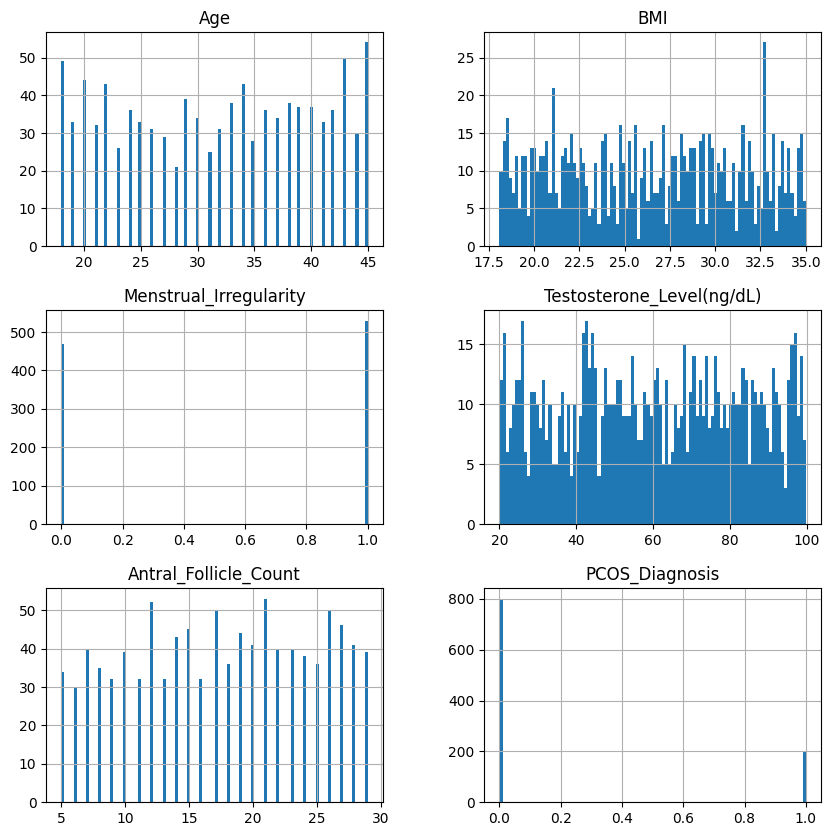

In [5]:
df.hist(bins=100, figsize=(10,10))
plt.show()

Ни одно из распределений, очевидно, не является нормальным.

In [6]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('PCOS_Diagnosis', axis=1),
                                                    df['PCOS_Diagnosis'],
                                                    test_size=0.2,
                                                    random_state=35)

In [7]:
def get_youden_j(column):

  fpr_train, tpr_train, thresholds_train = roc_curve(y_train, X_train[column])

  youden_j = tpr_train - fpr_train

  optimal_idx = np.argmax(youden_j)
  optimal_threshold = thresholds_train[optimal_idx]

  y_pred_test = (X_test[column] >= optimal_threshold).astype(int)

  sensitivity_test = recall_score(y_test, y_pred_test)
  precision_test = precision_score(y_test, y_pred_test, zero_division=0)
  accuracy_test = accuracy_score(y_test, y_pred_test)
  f1_test = f1_score(y_test, y_pred_test)

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred_test).ravel()
  specificity_test = tn / (tn + fp) if (tn + fp) > 0 else 0

  print(f"Признак: {column}")
  print(f"Оптимальный порог по Юдену: {optimal_threshold:.4f}")
  print(f"На тестовых данных при этом пороге:")
  print(f"  Чувствительность:\t{sensitivity_test:.4f}")
  print(f"  Специфичность:\t{specificity_test:.4f}")
  print(f"  Точность:\t\t\t{accuracy_test:.4f}")
  print(f"  F-мера:\t\t\t{f1_test:.4f}")

  fpr, tpr, thresholds = roc_curve(y_test, X_test[column])
  roc_auc = auc(fpr, tpr)

  display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
  display.plot()

Признак: Testosterone_Level(ng/dL)
Оптимальный порог по Юдену: 41.2000
На тестовых данных при этом пороге:
  Чувствительность:	1.0000
  Специфичность:	0.3152
  Точность:			0.4350
  F-мера:			0.3825


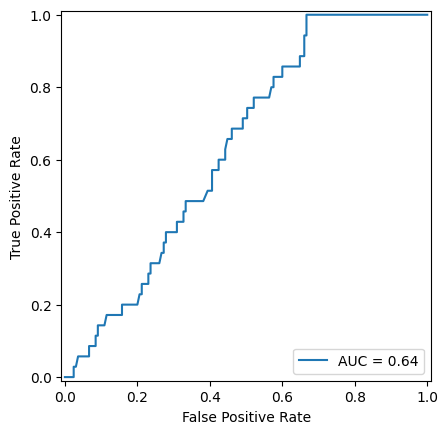

In [8]:
get_youden_j('Testosterone_Level(ng/dL)')

Признак: Menstrual_Irregularity
Оптимальный порог по Юдену: 1.0000
На тестовых данных при этом пороге:
  Чувствительность:	1.0000
  Специфичность:	0.5697
  Точность:			0.6450
  F-мера:			0.4965


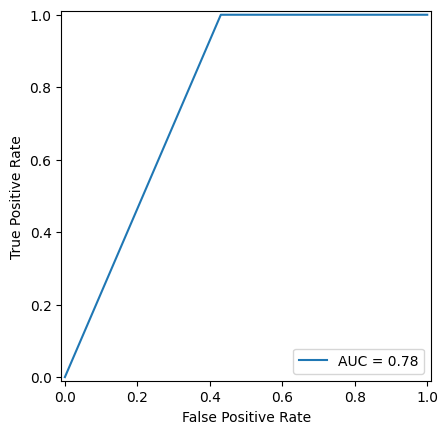

In [9]:
get_youden_j('Menstrual_Irregularity')

Признак: Antral_Follicle_Count
Оптимальный порог по Юдену: 11.0000
На тестовых данных при этом пороге:
  Чувствительность:	1.0000
  Специфичность:	0.2545
  Точность:			0.3850
  F-мера:			0.3627


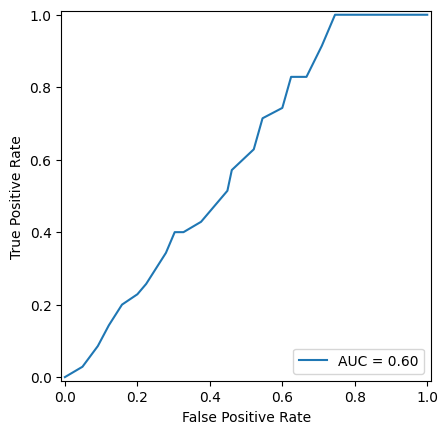

In [10]:
get_youden_j('Antral_Follicle_Count')

Таким образом, если смотреть по отдельным признакам, наибольшей предсказательной силой обладает признак нарушения менструального цикла, но точность низкая везде.

Теперь попробуем посмотреть сразу по нескольким признакам: построим неглубокое дерево решений (аналогично статье)

In [11]:
def get_results(y_test, y_pred):
  accuracy = tree.score(X_test, y_test)
  sensitivity = recall_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred, zero_division=0)
  f1 = f1_score(y_test, y_pred)

  tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
  specificity = tn / (tn + fp) if (tn + fp) > 0 else 0

  print(f"Чувствительность:\t{sensitivity:.4f}")
  print(f"Специфичность:\t\t{specificity:.4f}")
  print(f"Точность:\t\t{accuracy:.4f}")
  print(f"F-мера:\t\t\t{f1:.4f}")

In [12]:
tree = DecisionTreeClassifier(max_depth=4, random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

get_results(y_test, y_pred)

Чувствительность:	0.9714
Специфичность:		1.0000
Точность:		0.9950
F-мера:			0.9855


In [13]:
# Экспортируем правила в текст
tree_rules = export_text(
    tree,
    feature_names=X_train.columns
)
print("ПРАВИЛА ДЕРЕВА РЕШЕНИЙ:")
print(tree_rules)

ПРАВИЛА ДЕРЕВА РЕШЕНИЙ:
|--- Menstrual_Irregularity <= 0.50
|   |--- class: 0
|--- Menstrual_Irregularity >  0.50
|   |--- BMI <= 25.15
|   |   |--- class: 0
|   |--- BMI >  25.15
|   |   |--- Testosterone_Level(ng/dL) <= 40.80
|   |   |   |--- class: 0
|   |   |--- Testosterone_Level(ng/dL) >  40.80
|   |   |   |--- Antral_Follicle_Count <= 10.50
|   |   |   |   |--- class: 0
|   |   |   |--- Antral_Follicle_Count >  10.50
|   |   |   |   |--- class: 1



То есть по сути мы прежде всего отсеиваем тех, у кого нет проблем с циклом, затем проверяем, есть ли проблемы с лишним весом, уже затем смотрим на уровень тестостерона и в последнюю очередь на количество антральных фолликулов. При этом это уже даёт весьма хорошую точность, чувствительность и глубину, при этом давая интерпретируемый результат, которым могут пользоваться, например, врачи.

Ради интереса посмотрим, можем ли мы поднять эти метрики менее интерпретируемыми способами.

In [14]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

get_results(y_test, y_pred)

Чувствительность:	0.9714
Специфичность:		1.0000
Точность:		0.9950
F-мера:			0.9855


In [15]:
rfc = RandomForestClassifier(random_state=35)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

get_results(y_test, y_pred)

Чувствительность:	0.9714
Специфичность:		1.0000
Точность:		0.9950
F-мера:			0.9855


In [16]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [17]:
gbr = GradientBoostingClassifier(random_state=35)
gbr.fit(X_train_scaled, y_train)
y_pred = gbr.predict(X_test_scaled)

get_results(y_test, y_pred)

Чувствительность:	0.9714
Специфичность:		1.0000
Точность:		0.9950
F-мера:			0.9855


Кажется, это какие-то странности в данных, которые не предсказываются уже никакими способами. Получается, для нашей задачи больше всего подходит обычное неглубокое дерево решений, поскольку именно оно даёт возможность интерпретировать результат и при этом обеспечивает высокую точность.